# Тесты с генетическим алгоритмом (Пресеты и ветви)

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [2]:
def print_NRS_graph(model):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        plt.show()

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model):
    '''
    Построение графа НРС
    '''
    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nx.draw(G, with_labels=True)
    plt.show()

    return G
# from workFolder.nrs import q_out_simple

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'НРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)
            
        return super().appendElement(elmnt)
       
    def insertElement(self, elmnt:Element, elmntInsert:Element, pos=0):
        '''
        Вставка элемента в модель НРС.

        `elmnt`: Element
            Элемент относительно которого нужно вставить. Если не указан, вставляется элемент по правилам.

        `pos`: int
            Позиция: 0 - до элемента, 1 после.
        '''

        # До элемента
        if pos==0:
            print(0)
            if len(elmnt.elements_previous)>0:
                elmnt_in = random.choice(elmnt.elements_previous)
                elmnt.elements_previous.remove(elmnt_in)
                elmnt_in.elements_next.remove(elmnt)

                elmnt_in.append(elmntInsert).append(elmnt)
        # После элемента
        elif pos==1:
            print(1)
            if len(elmnt.elements_next)>0:
                elmnt_to = random.choice(elmnt.elements_next)
                elmnt.elements_next.remove(elmnt_to)
                elmnt_to.elements_previous.remove(elmnt)

                elmnt.append(elmntInsert).append(elmnt_to)            

        return self

    def getNewElement(self, elmnt:Element, pos=0):
        '''
        Правила добавления новых элементов
        '''
        if pos==0:
            return allowed_prepend_classes[elmnt.id]
        elif pos==1:
            return allowed_append_classes[elmnt.id]


    def crossing(self, pair_model):
        return self

    def mutate(self, mutation_count=1):
        '''
        Мутация элементов модели
        '''

        # Микромутации
        for _ in range(mutation_count):
            var = random.choice([0,1,2,3,4])
            
            # микромутации
            if var==0:
                random.choice(self.elmnts).mutate()
            # удаление элемента
            if var==1:
                print('удаление элемента')
                self.delElement(random.choice(self.elmnts))
            # замена элемента
            if var==2:
                print('замена элемента')
                # pump <-> joiner <-> splitter
                # nozzle -> splitter
                elmnt_classes = [GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter, GA_Element_Nozzle]
                elmnt_class = random.choice(
                    elmnt_classes
                    )
                elmnt = pop_random_element_by_class(self.elmnts, elmnt_class)
                if elmnt:
                    if isinstance(elmnt, elmnt_classes[0]):
                        # Если насос:
                        if random.choice(True,False):
                            # В разветвление:
                            new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=self.ro)
                        else:
                            # В водосборник
                            new_elmnt = GA_Element_Joiner('', e_type=1, ri=self.ri, ro=1)
                    elif isinstance(elmnt, elmnt_classes[1]):
                        # Если водосборник
                        # В насос
                        new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                    elif isinstance(elmnt, elmnt_classes[2]):
                        # Если разветвление
                        if random.choice(True,False):
                            # В насос
                            new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                        else:
                            # В ствол (пока только А)
                            new_elmnt = GA_Element_Nozzle('', e_type=2, n_type='А', p=NRS_Revision.calc_p(7.4, 40), q_out = q_out_nozzle)
                    elif isinstance(elmnt, elmnt_classes[3]):
                        # Если ствол
                        # В разветвление
                        new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=3)

                    elmnts_next = elmnt.elements_next
                    elmnts_prev = elmnt.elements_previous
                    self.delElement(elmnt)
                    new_elmnt.add_links(elmnts_prev, elmnts_next)
                        

            # вставка элемента
            if var==3:
                print('вставка элемента')
                elmnt = random.choice(self.elmnts)
                pos = random.choice([0,1])
                new_elmnt = self.getNewElement(elmnt, pos)
                self.insertElement(elmnt, new_elmnt, pos)
            # добавление ветви из пресета
            if var==4:
                print('добавление ветви из пресета')
                # Определяем какие есть входы и выходы и исходя из этого добавляем ветвь нужного типа
            
            # Если несколько компонентов;
            # соединение выход -> вход

            # соединение вход -> выход

        return self


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > self.H_max:
            self.H_add = self.H_max
        else:
            self.H_add = H_add
        if H_add <= self.H_min:
            self.H_add = self.H_min
        else:
            self.H_add = H_add

    def mutate(self):
        mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.H_add+=change_val
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)




class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-5,5)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества выходов
        change_val = random.choice([2,3,4,5])
        # if change_val < self.ro:
        #     print('Удаляется', self.name)
        self.set_ro(change_val)

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        change_val = random.choice([2,3,4,5])
        self.set_ri(change_val)

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)


# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }



#=====================================Оценщик=====================================================================================================
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        print('='*80)
        print(model.name)
        print('='*80)
        
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict, aims_not_more=None):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        `aims_not_more`: dict
            Словарь целей оптимизации значения которых не могут быть выше некоторого значения.
            Например, если в модели не должно присутствовать более 10 рукавов диаметром 77мм.
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)
        if aims_not_more:
            for aim, aim_val in aims_not_more.items():
                if aim in metrics.keys():
                    metric_val = metrics[aim]
                    if metric_val>aim_val:
                        max_val = max(aim_val, metric_val)
                        X.append(metric_val/max_val)
                        Y.append(aim_val/max_val)

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)





#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()


#==============================================Рекурсии=========================================================================
# Рекурсивное построение дерева
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)


def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model


#==================================================== Класс ветви =================================================
class Branch(NRS_Model):
    '''
    Класс ветви модели. Может быть трех типов:

    `FULL=0` Имеет и источник и потребитель (насос и ствол).
        Например простая модель НРС АЦ->Рукав->Ствол.

    `INWARD=1` Имеет только вход. Выход открыт (оканчивается рукавом)
        Например, Рукавные линии начинающиеся от насосов. Могут подключаться на вход к водосборникам или насосам.

    `OUTWARD=2` Имеет только выход. Вход открыт (начинается с рукава). 
        Например, рабочие рукавные линии. Могут подключаться на выход к разветвлениям или насосам.

    `-1` Не распознана.
    '''

    def __init__(self, name=''):
        self.elmnts_names = []
        self._branch_type = -1
        super().__init__(name)

    def getBranch(self, model:NRS_Model, elmnt=None):
        '''
        Из `model` выделяется ветвь в которую входит элемент `elmnt`. 
        Если `elmnt` не передан, он выбирается случайно.
        '''
        # Если элемент не передан, выбираем его случайным образом
        if elmnt is None:
            elmnt = random.choice(model.elmnts)
        # Если передано имя элемента, получаем его по имени, иначе предполагается использование объекта
        if isinstance(elmnt, str):
            elmnt = model.getElement(elmnt)
        if not isinstance(elmnt, Element):
            raise TypeError('Должен быть элемент НРС!')

        self._elementAdd(elmnt)

        return self
    
        
    def _elementAdd(self, elmnt:Element):
        '''
        Рекурсивное добавление элементов в модель
            Вход:
                elmnt=Element: элемент который следует добавить модель. 
                Далее _elementAdd будет вызвана для всех подключенных к нему элементов
        '''
        if not elmnt in self.elmnts:
            self.addElements([elmnt])
            for linked in elmnt.elements_next:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Nozzle)):
                    self._elementAdd(linked)
            for linked in elmnt.elements_previous:
                if isinstance(linked, (GA_Element_Hose, GA_Element_Pump)):
                    self._elementAdd(linked)

    def interpretate(self):

        super().interpretate()
        # Определение типа ветви
        if len(self.elmnts_in)>0 and len(self.elmnts_out)>0:
            self._branch_type = 0
        elif len(self.elmnts_in)>0 and len(self.elmnts_out)==0:
            self._branch_type = 1
        elif  len(self.elmnts_in)==0 and len(self.elmnts_out)>0:
            self._branch_type = 2
        # Определение входных элементов
        for elmnt in self.elmnts:
            if len(self.elmnts_in) + len(self.elmnts_out) ==1:
                self.plugin = elmnt

        return self
    
    @property
    def branch_type(self):
        t = {0:'ПОЛНАЯ', 1:'ВХОДЯЩАЯ', 2:'ИСХОДЯЩАЯ', -1:'НЕ РАСПОЗНАНО'}
        return t[self._branch_type]
    
    def deep_copy(self):
        '''
        Делает глубокую копию элементов. Требуется для удаления связей с исходной моделью.
        '''
        tmp_col = []
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            tmp_col.append(copy.deepcopy(elmnt).drop_links())
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            elmnt_copy = NRS_Revision.get_element_by_name(tmp_col, elmnt.name, False)
            for linked in elmnt.elements_next:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    elmnt_copy.append(linked_copy)
            for linked in elmnt.elements_previous:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    linked_copy.append(elmnt_copy)

        self.elmnts = tmp_col
        
        return self
    
    def drop_names(self):
        '''
        Обезличивает (удаляет имена) элементов ветви.
        Требуется для корректной передачи в другие модели, где элементы будут переименованы в соответствии с моделью.
        '''
        for elmnt in self.elmnts:
            elmnt.name = ''
        return self
    
    def plug(self, elmnt):
        '''
        Прививает ветвь к указанному элементу.

        Если ветвь входящая, то прививается на вход (если возможно). 
        Если исходящая - на выход (если возможно)
        Если полная или нераспознанная, ничего не происходит
        '''
        # ВХОДЯЩАЯ
        if self._branch_type==1:
            self.plugin.append(elmnt)
        # ИСХОДЯЩАЯ
        if self._branch_type==2:
            elmnt.append(self.plugin)

        return self

# Пресеты

Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м


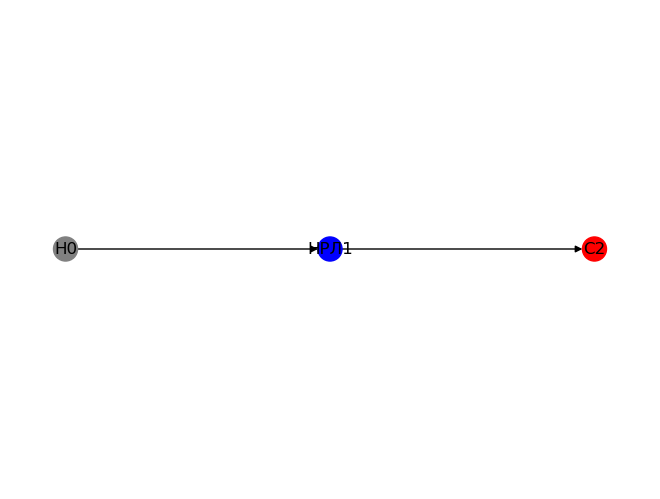

In [3]:
class Presets():

    @staticmethod
    def single_line():
        '''
        Простая НРС с одной РРЛ и одним стволом

            |=|>-------------|->
        '''
        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)

        pump.append(hose).append(nozzle)

        model = GA_model('Простая НРС с одной РРЛ и одним стволом')
        model.addElements([pump,hose,nozzle])
        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_splitter(nozzles_count=2):
        '''
        Сложная НРС с одним разветвлением и nozzles_count рабочих линий

                             ------|->
            |=|>------{------|->
                             ------|->
            
        '''
        if not nozzles_count in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с одним разветвлением и nozzles_count рабочих линий')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM).append(spliiter)

        model.addElements([pump,hoseM,spliiter])

        for _ in range(nozzles_count):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def two_splitter(nozzles_count1=2, nozzles_count2=2):
        '''
        Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка

                             ------|->          ------|->
            |=|>------{------------------{------|->
                             ------|->          ------|->
            
        '''
        if not nozzles_count1 in [1,2]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 2!")
        if not nozzles_count2 in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter1 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter2 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM1).append(spliiter1).append(hoseM2).append(spliiter2)

        model.addElements([pump,hoseM1,spliiter1,hoseM2,spliiter2])

        for _ in range(nozzles_count1):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter1.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        for _ in range(nozzles_count2):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter2.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        
        return model.check_pumps().interpretate()

    @staticmethod
    def single_joiner(nozzle_q=20, nozzle_workpress=60):
        '''
        Сложная НРС с одним водосборником и лафетным стволом

            |=|>------
                             }------|-,->
            |=|>------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        pump2 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner)
        pump2.append(hoseM2).append(joiner)
        joiner.append(hoseW1).append(nozzle)

        model.addElements([pump1,hoseM1,pump2,hoseM2,joiner,hoseW1,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_pump_to_joiner_by2(nozzle_q=20, nozzle_workpress=60):
        '''
        Простая НРС с одним, насосом, водосборником и лафетным стволом

                    ------
            |=|>...............}------|-,->
                    ------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        hoseM2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=1)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner).append(hoseW).append(nozzle)
        pump1.append(hoseM2).append(joiner)

        model.addElements([pump1,hoseM1,hoseM2,joiner,hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def n_components(n=2):
        '''
        Простая НРС из n компонентов в виде простых НРС

            n * |=|>-------------|->
            
        '''
        model = GA_model(f'Простая НРС из {n} компонентов в виде простых НРС')

        for _ in range(n):
            for e in Presets.single_line().elmnts:
                e.name=''
                model.addElements([e])

        return model.check_pumps().interpretate()


model = Presets.single_line()
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


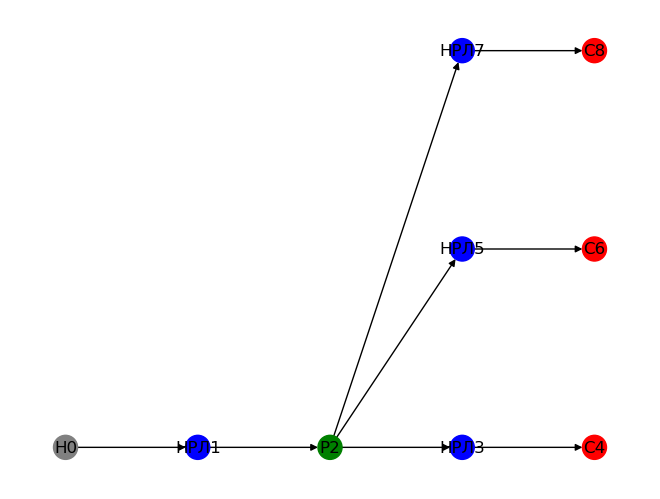

In [4]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка
Расстояние до Н0 120 м


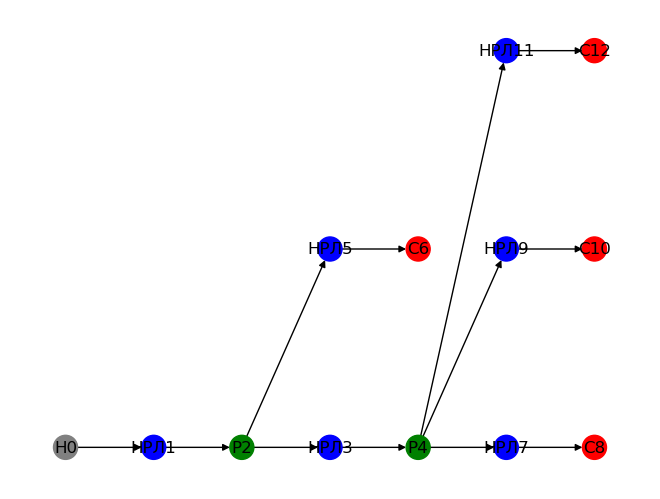

In [5]:
model = Presets.two_splitter(nozzles_count1=1, nozzles_count2=3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Расстояние до Н0 80 м
Расстояние до Н2 80 м


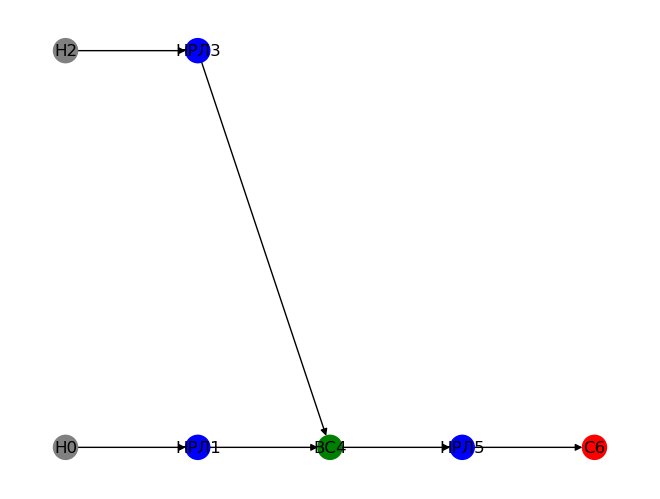

In [6]:
model = Presets.single_joiner(30)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Расстояние до Н0 60 м


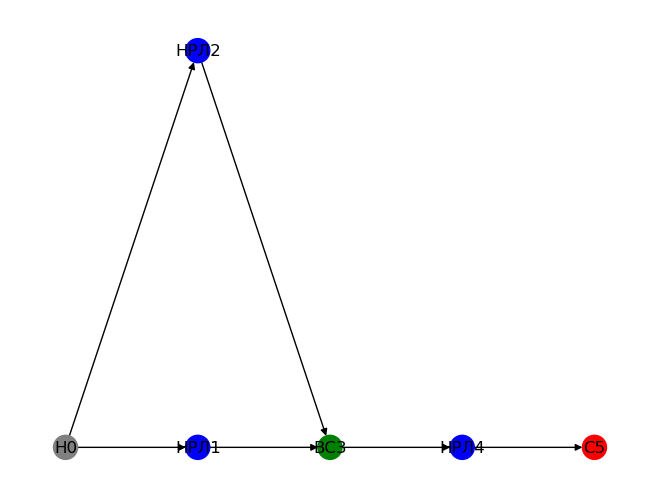

In [7]:
model = Presets.single_pump_to_joiner_by2()
print_NRS_graph(model)

Новая модель: Простая НРС из 3 компонентов в виде простых НРС
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Простая НРС с одной РРЛ и одним стволом
Расстояние до Н0 40 м
Расстояние до Н3 40 м
Расстояние до Н6 40 м


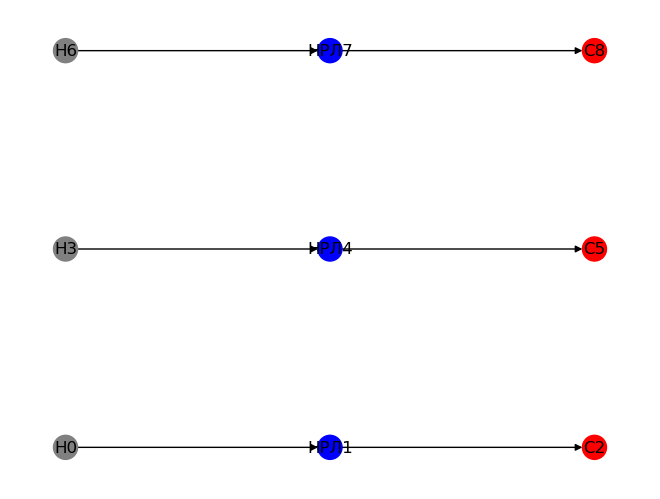

In [8]:
model = Presets.n_components(3)
print_NRS_graph(model)

In [8]:
# Расчет
try:
    model.calc(accuracy=0.05)
except Exception as e:
    print(e.args[0])
print(f'Общий расход системы: {model.summaryQ()} л/с', end='\n\n')

# Состав
NRS_Revision.print_model_elements(model)
Appraiser.print_GA_NRS_model_elements_state(model)

Общий расход системы: 10.640572147070957 л/с

all:
  Н0
  НРЛ1
  С2
  Н3
  НРЛ4
  С5
  Н6
  НРЛ7
  С8
in:
  Н0
  Н3
  Н6
out:
  С2
  С5
  С8
Простая НРС из 3 компонентов в виде простых НРС
Насос (Н0); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н3); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100
Насос (Н6); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ4), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 3.2426667909999995 м

Ствол (С2): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С5): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с
Ствол (С8): "

# Тесты

In [9]:
# p_nozzleB = NRS_Revision.calc_p(3.7, 40)
# p_nozzleA = NRS_Revision.calc_p(7.4, 40)
# p_nozzleL = NRS_Revision.calc_p(16, 40)
# p_nozzleB, p_nozzleA, p_nozzleL

# Мутации

## Тест макромутаций

Макромутации - мутации в структуре модели. Добавление, изменение и удаление элементов модели.

## Тест корректного удаления элементов

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


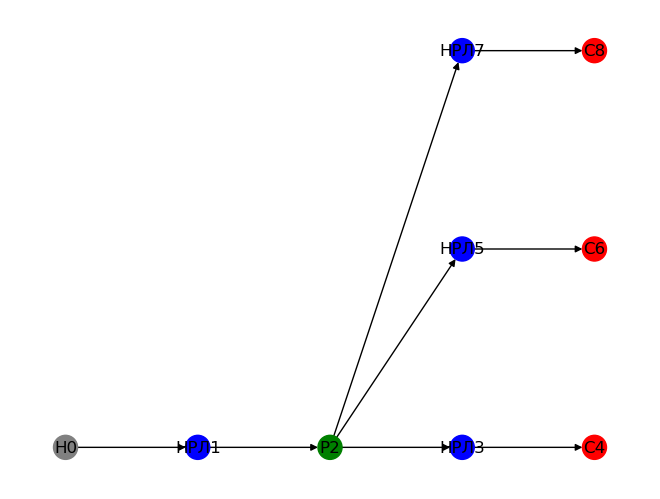

In [10]:
model = Presets.single_splitter(3)
print_NRS_graph(model)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


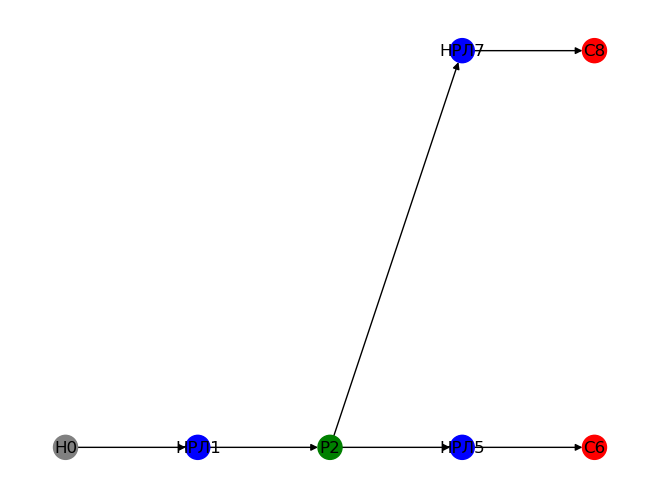

In [11]:
model = Presets.single_splitter(3)
model.getElement('Р2').set_ro(2)
for e in model.elmnts:
    model.fire_dead_elements_try(e)
print_NRS_graph(model)

### Проверка обучения

С удалением ветвей

In [12]:
model = Presets.single_splitter(3)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий


In [13]:
aims = {'Q':15, '38дв':0, '51нп':0, '89':0,'110': 0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 800, 'max_L': 800}

curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
for i in range(2000):
    print(f'{i}\t', end='\r')
    model_back = copy.deepcopy(model)
    to_print = i%100==0
    try:
        model.mutate(mutation_count=2)
        for elmnt in model.elmnts:
            model.fire_dead_elements_try(elmnt)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
        if newQ>curQ:
            model = model_back
        if newQ<curQ:
        # if to_print:
            curQ=newQ
            print(i, newQ, model.summaryQ(), sep='\t')
    except:
        # print(i, 'Модель не жизнеспособна')
        model = model_back

print('Итог:', curQ, model.summaryQ(), sep='\t')

0	0.7057158958283042	10.24278468772631
3	0.6506974359351657	12.718615382917545
6	0.6347474091523234	12.311366588145447
24	0.6299109475987625	12.154007358055685
33	0.61984215980225	11.857102808898748
47	0.5988549394062084	11.301527726720622
59	0.5838245833225325	11.977893750486034
74	0.5676783368233119	12.704474842950964
100	0.5635277471738233	12.891251377177955
103	0.5480317315432245	13.5885720805549
121	0.5159642843844695	13.531607202698876
139	0.5012873474632548	14.192069364153532
149	0.49848988053123144	14.317955376094584
154	0.4910053516453196	14.279759175960615
155	0.4895840572479416	14.343717423842627
167	0.47541057242220996	14.981524241000551
179	

	0.4674203734102563	14.591083196538467
181	0.43515050345183454	14.543227344667446
184	0.42801843827573566	15.137070942950178
216	0.3937437928438674	15.094056781382289
220	0.3809429413940384	13.98256763726827
227	0.3556857978564654	14.369139096459055
239	0.34465648124806264	14.865458343837181
254	0.3439058849718324	14.899235176267544
303	0.3436319922052884	14.911560350762024
305	0.33534732177812715	14.909370519984279
325	0.31271309878830544	14.427910554526255
329	0.295266017654266	14.83802920555803
331	0.2840433068056169	13.843051193747241
350	0.27573454916319823	14.216945287656081
424	0.274392431348446	14.27734058931993
438	0.2738660397296235	14.29188187070353
449	0.2713295115771259	14.40602563756592
463	0.2539404489261522	14.82267979832315
477	0.22387209619823137	14.675755671079589
491	0.22025947109981	14.534431734011399
507	0.17026852050439667	14.5338887697362
594	0.16996655283403284	15.461784936548778
652	0.16754945577031624	15.30921277106338
653	0.16620872943837867	15.6223135764369

Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0); напор: 75 м; производительность: 14.856561361176537 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 140 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 24.62569866940084 м
Рукавная линия (НРЛ3), длина: 180 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 15.786681365181419 м
Рукавная линия (НРЛ5), длина: 200 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 0.08175667337710635 м
Рукавная линия (НРЛ7), длина: 660 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 7.590508780603871 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 34.587619965417744, м; расход: 6.881166451456968, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 50.29254465722205, м; расход: 4.148809878619922, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 42.78379254999529, м; расход: 3.826585031099647, л/с
hoses	59
nozzles	3
distances	{'Н0': {'С4': 320, 'С6': 340, 'С8': 800}}
m

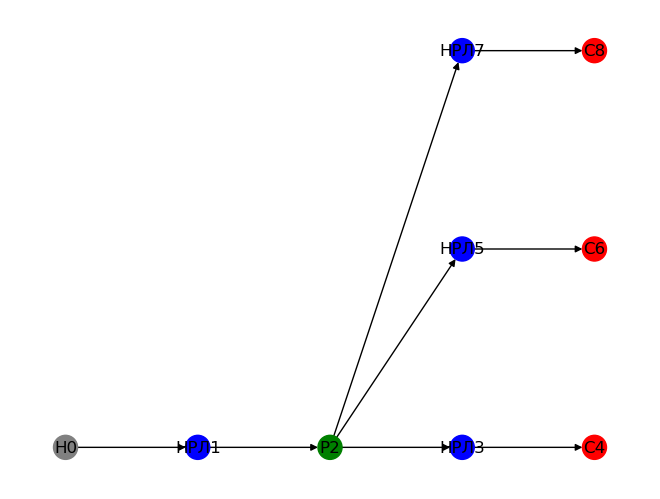

In [14]:
Appraiser.print_GA_NRS_model_elements_state(model)
print('='*80)
Appraiser.print_metrics(model)
print_NRS_graph(model)

## Класс ветви

In [11]:
# class Branch(NRS_Model):
#     '''
#     Класс ветви модели. Может быть трех типов:

#     `FULL=0` Имеет и источник и потребитель (насос и ствол).
#         Например простая модель НРС АЦ->Рукав->Ствол.

#     `INWARD=1` Имеет только вход. Выход открыт (оканчивается рукавом)
#         Например, Рукавные линии начинающиеся от насосов. Могут подключаться на вход к водосборникам или насосам.

#     `OUTWARD=2` Имеет только выход. Вход открыт (начинается с рукава). 
#         Например, рабочие рукавные линии. Могут подключаться на выход к разветвлениям или насосам.

#     `-1` Не распознана.
#     '''

#     def __init__(self, name=''):
#         self.elmnts_names = []
#         self._branch_type = -1
#         super().__init__(name)

#     def getBranch(self, model:NRS_Model, elmnt=None):
#         '''
#         Из `model` выделяется ветвь в которую входит элемент `elmnt`. 
#         Если `elmnt` не передан, он выбирается случайно.
#         '''
#         # Если элемент не передан, выбираем его случайным образом
#         if elmnt is None:
#             elmnt = random.choice(model.elmnts)
#         # Если передано имя элемента, получаем его по имени, иначе предполагается использование объекта
#         if isinstance(elmnt, str):
#             elmnt = model.getElement(elmnt)
#         if not isinstance(elmnt, Element):
#             raise TypeError('Должен быть элемент НРС!')

#         self._elementAdd(elmnt)

#         return self
    
        
#     def _elementAdd(self, elmnt:Element):
#         '''
#         Рекурсивное добавление элементов в модель
#             Вход:
#                 elmnt=Element: элемент который следует добавить модель. 
#                 Далее _elementAdd будет вызвана для всех подключенных к нему элементов
#         '''
#         if not elmnt in self.elmnts:
#             self.addElements([elmnt])
#             for linked in elmnt.elements_next:
#                 if isinstance(linked, (GA_Element_Hose, GA_Element_Nozzle)):
#                     self._elementAdd(linked)
#             for linked in elmnt.elements_previous:
#                 if isinstance(linked, (GA_Element_Hose, GA_Element_Pump)):
#                     self._elementAdd(linked)

#     def interpretate(self):

#         super().interpretate()
#         # Определение типа ветви
#         if len(self.elmnts_in)>0 and len(self.elmnts_out)>0:
#             self._branch_type = 0
#         elif len(self.elmnts_in)>0 and len(self.elmnts_out)==0:
#             self._branch_type = 1
#         elif  len(self.elmnts_in)==0 and len(self.elmnts_out)>0:
#             self._branch_type = 2
#         # Определение входных элементов
#         for elmnt in self.elmnts:
#             if len(self.elmnts_in) + len(self.elmnts_out) ==1:
#                 self.plugin = elmnt

#         return self
    
#     @property
#     def branch_type(self):
#         t = {0:'ПОЛНАЯ', 1:'ВХОДЯЩАЯ', 2:'ИСХОДЯЩАЯ', -1:'НЕ РАСПОЗНАНО'}
#         return t[self._branch_type]
    
#     def deep_copy(self):
#         '''
#         Делает глубокую копию элементов. Требуется для удаления связей с исходной моделью.
#         '''
#         tmp_col = []
#         for elmnt in self.elmnts:
#             # print(tmp_col, elmnt.name)
#             tmp_col.append(copy.deepcopy(elmnt).drop_links())
#         for elmnt in self.elmnts:
#             # print(tmp_col, elmnt.name)
#             elmnt_copy = NRS_Revision.get_element_by_name(tmp_col, elmnt.name, False)
#             for linked in elmnt.elements_next:
#                 linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
#                 if linked_copy:
#                     elmnt_copy.append(linked_copy)
#             for linked in elmnt.elements_previous:
#                 linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
#                 if linked_copy:
#                     linked_copy.append(elmnt_copy)

#         self.elmnts = tmp_col
        
#         return self
    
#     def drop_names(self):
#         '''
#         Обезличивает (удаляет имена) элементов ветви.
#         Требуется для корректной передачи в другие модели, где элементы будут переименованы в соответствии с моделью.
#         '''
#         for elmnt in self.elmnts:
#             elmnt.name = ''
#         return self
    
#     def plug(self, elmnt):
#         '''
#         Прививает ветвь к указанному элементу.

#         Если ветвь входящая, то прививается на вход (если возможно). 
#         Если исходящая - на выход (если возможно)
#         Если полная или нераспознанная, ничего не происходит
#         '''
#         # ВХОДЯЩАЯ
#         if self._branch_type==1:
#             self.plugin.append(elmnt)
#         # ИСХОДЯЩАЯ
#         if self._branch_type==2:
#             elmnt.append(self.plugin)

#         return self
    



# Рассматриваемая модель НРС
model = Presets.single_splitter(3)

branch = Branch().getBranch(model, 'НРЛ1').deep_copy().interpretate()  #.check_pumps().interpretate()
NRS_Revision.print_model_elements(branch)


# print_NRS_graph(branch)
print(branch.branch_type)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: 
all:
  НРЛ1
  Н0
in:
  Н0
out:
ВХОДЯЩАЯ


In [16]:
Appraiser.print_GA_NRS_model_elements_state(branch)


Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м



Расстояние до Н0 80 м


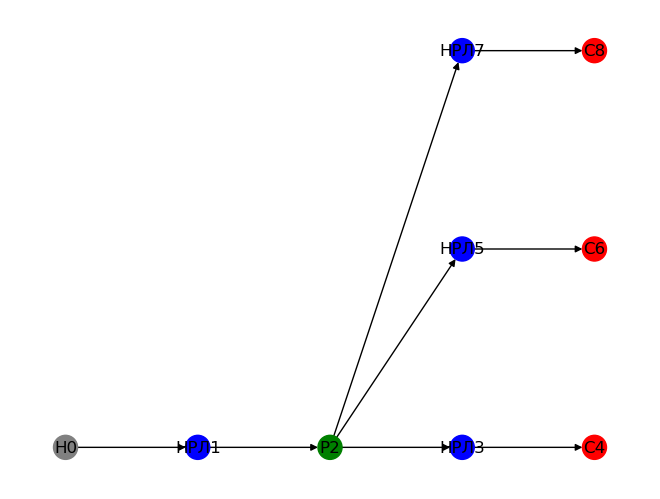

Расстояние до Н0 0 м


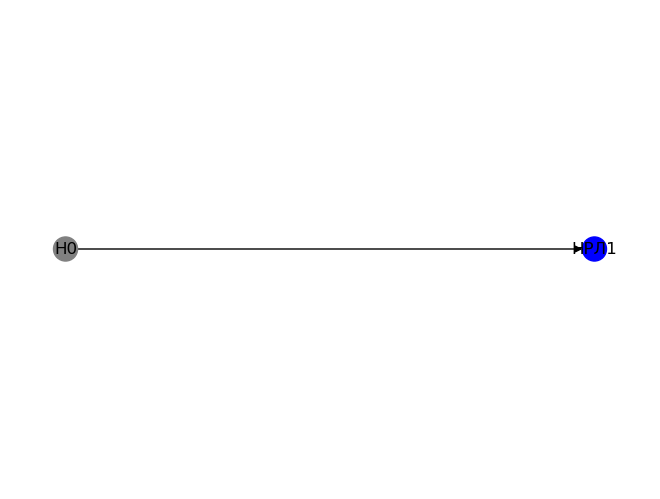

In [17]:
print_NRS_graph(model)
print_NRS_graph(branch)

### Прививка ветви другой модели (на выход)

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
in:
  Н0
out:
  С4
  С6
Модель для прививки
Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м


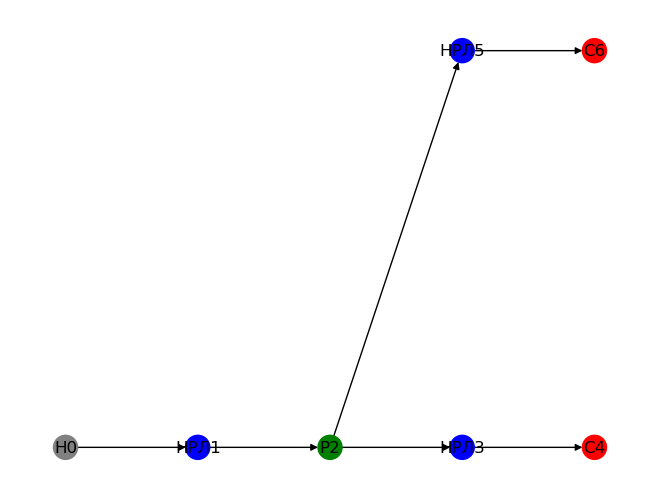

Новая модель: 
all:
  С6
  НРЛ5
in:
out:
  С6
ИСХОДЯЩАЯ


In [18]:
# Модель у которой получаем ветвь
model1 = Presets.single_splitter(3)
# Модель которой будем ее прививать
model2 = Presets.single_splitter()
model2.name = 'Модель для прививки'
NRS_Revision.print_model_elements(model2)
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

# Получение ветви
branch = Branch().getBranch(model1, 'С6').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
print(branch.branch_type)

# Прививка ветви
branch.drop_names().plug(NRS_Revision.get_element_by_name(model2.elmnts, 'Р2', False))
model2.addElements(branch.elmnts).interpretate().check_pumps()

all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  С7
  НРЛ8
in:
  Н0
out:
  С4
  С6
  С7
Расстояние до Н0 80 м


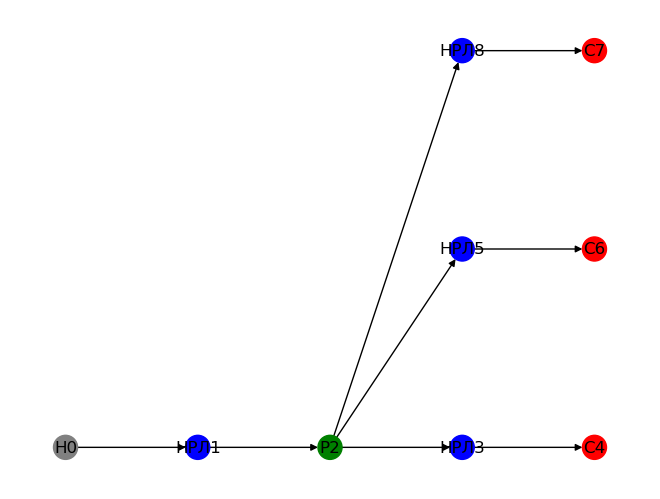

In [19]:
NRS_Revision.print_model_elements(model2)
print_NRS_graph(model2)

all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  С7
  НРЛ8
in:
  Н0
out:
  С4
  С6
  С7
Расстояние до Н0 80 м


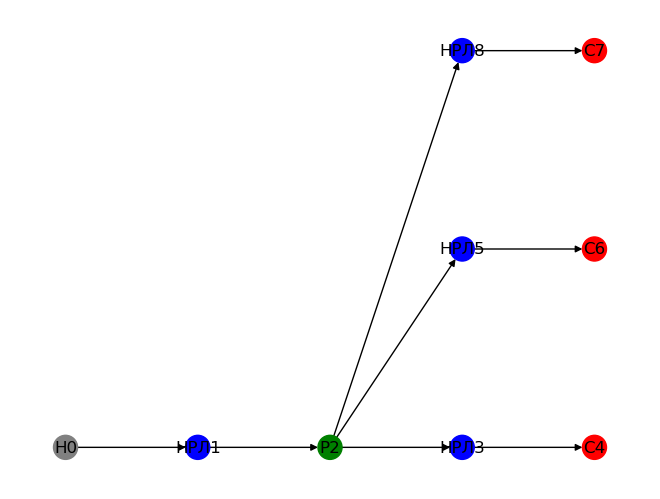

0	0.6370200845088362	10.334096197102372
1	0.5806331969267332	17.48047179424871
5	0.5371818850246357	12.576815173891392
8	0.4865783408628577	11.853974661171407
14	0.48651907664628286	13.558855401223028
15	0.4728110350166838	14.381337898998973
28	0.44398554269526463	14.610867438284119
30	0.3444594312084618	14.582434127492295
32	0.3435378235494755	15.371235224081953
38	0.34199622113199035	14.730226732080581
51	0.34058114493784764	15.18717555634251
53	0.1394464469164282	15.117703227321185
54	0.12556698844239908	14.965980693456055
219	0.11571968860650023	14.806818683609988
314	0.1141110429993257	14.867623134326173
420	0.10132775565889682	14.92033466046619
503	0.10039960664989933	14.976023601006041
731	0.10002347128383707	15.001408409258918
960	0.09908270601549629	14.932433412474143
Итог:	0.09908270601549629	14.932433412474143
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  С7
  НРЛ8
in:
  Н0
out:
  С4
  С6
  С7
Расстояние до Н0 400 м


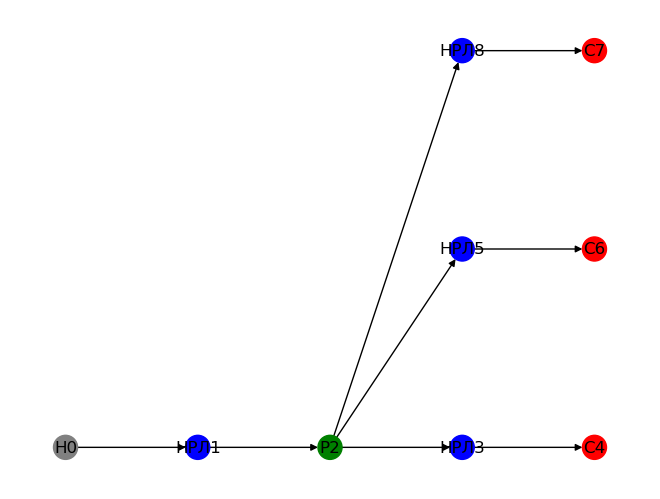

In [20]:
def fit(model, aims, aims_not_more=None, epochs=1000):
    curQ = Appraiser.evaluate(Appraiser.metrics(model), aims, aims_not_more)
    for i in range(epochs):
        print(f'{i}\t', end='\r')
        model_back = copy.deepcopy(model)
        try:
            model.mutate(mutation_count=2)
            for elmnt in model.elmnts:
                model.fire_dead_elements_try(elmnt)
            model.drop_q()
            kwargs = model.calc(accuracy=0.5)
            newQ = Appraiser.evaluate(Appraiser.metrics(model), aims, aims_not_more)
            if newQ>curQ:
                model = model_back
            if newQ<curQ:
                curQ=newQ
                print(i, newQ, model.summaryQ(), sep='\t')
        except:
            # print(i, 'Модель не жизнеспособна')
            model = model_back

    print('Итог:', curQ, model.summaryQ(), sep='\t')
    return model


work_model = copy.deepcopy(model2)

NRS_Revision.print_model_elements(work_model)
print_NRS_graph(work_model)

aims = {'Q':15, '38дв':0, '51нп':0, '89':0,'110': 0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}
aims_not_more = {'77':10}
work_model = fit(work_model, aims, aims_not_more)

NRS_Revision.print_model_elements(work_model)
print_NRS_graph(work_model)

In [21]:
Appraiser.print_GA_NRS_model_elements_state(work_model)
print('='*80)
Appraiser.print_metrics(work_model)
print('='*80)
aims

Модель для прививки
Насос (Н0); напор: 50 м; производительность: 14.932433412474143 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 200 м; диаметр: 150 мм; сопротивление 0.00046; потеря напора: 0.9870941292440756 м
Рукавная линия (НРЛ3), длина: 200 м; диаметр: 66 мм; сопротивление 0.034; потеря напора: 14.70605935400444 м
Рукавная линия (НРЛ5), длина: 180 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 2.160648581281339 м
Рукавная линия (НРЛ8), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0.4972969284603088 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 34.306846516751484, м; расход: 6.853179764272404, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 46.852257289474586, м; расход: 4.0043957168744795, л/с
Ствол (С7): "Б"; проводимость: 0.5850213671311502; напор: 48.515608942295614, м; расход: 4.0748579313272595, л/с
hoses	31
nozzles	3
distances	{'Н0': {'С7': 240, 'С6': 380, 'С4': 400}}
min_L	240
max_L	400
150	10
66	10
А	1
77	11


{'Q': 15,
 '38дв': 0,
 '51нп': 0,
 '89': 0,
 '110': 0,
 '150': 10,
 '200': 0,
 '225': 0,
 '250': 0,
 '300': 0,
 'min_L': 400,
 'max_L': 400}

### Прививка ко входу другой модели

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Новая модель: Сложная НРС с одним водосборником и лафетным стволом
Модель для прививки
Насос (Н0); напор: 80 м; производительность: 0 л/с; напор макс.: 100
Насос (Н2); напор: 80 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м

Ствол (С6): "Л"; проводимость: 2.581988897471611; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м
Расстояние до Н2 80 м


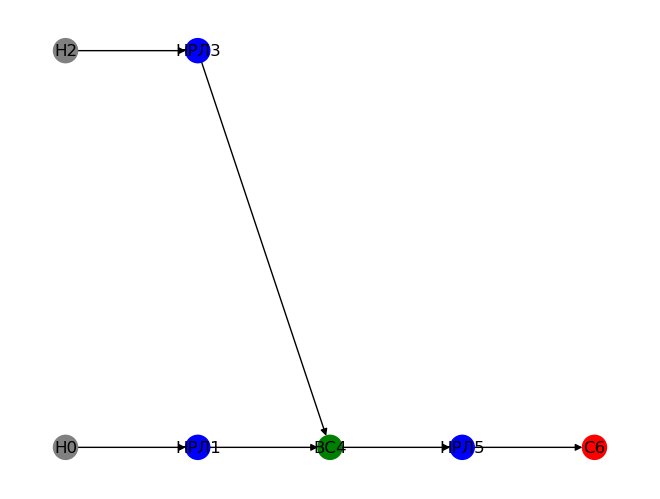

Новая модель: 
all:
  Н0
  НРЛ1
in:
  Н0
out:
ВХОДЯЩАЯ
Модель для прививки
Насос (Н0); напор: 80 м; производительность: 0 л/с; напор макс.: 100
Насос (Н7); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ8), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м

Ствол (С6): "Л"; проводимость: 2.581988897471611; напор: 0, м; расход: 0, л/с
Расстояние до Н0 80 м
Расстояние до Н7 80 м


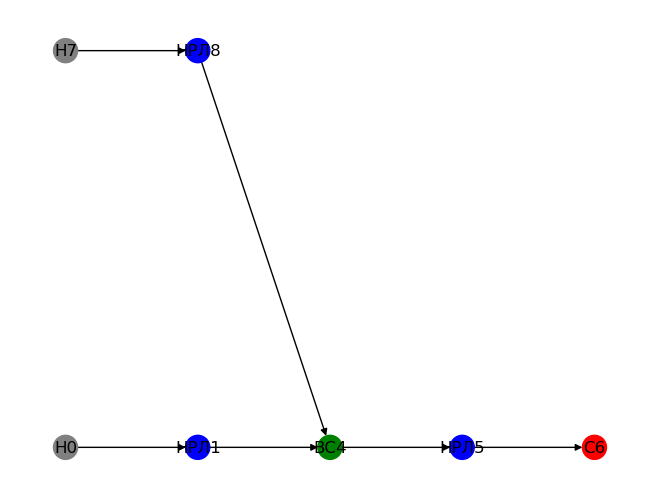

In [22]:
# Модель у которой получаем ветвь
model1 = Presets.single_splitter(3)
# Модель которой будем ее прививать
model2 = Presets.single_joiner()
model2.name = 'Модель для прививки'
# NRS_Revision.print_model_elements(model2)
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

# Удаление одной из ветвей
model2.delElement(NRS_Revision.get_element_by_name(model2.elmnts, 'Н2', False))
# Appraiser.print_GA_NRS_model_elements_state(model2)
# print_NRS_graph(model2)

# Получение ветви
branch = Branch().getBranch(model1, 'Н0').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
print(branch.branch_type)

# Прививка ветви
branch.drop_names().plug(NRS_Revision.get_element_by_name(model2.elmnts, 'ВС4', False))
model2.addElements(branch.elmnts).interpretate().check_pumps()
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

In [23]:
# Проверка расчета
aims = {'Q':15, '38дв':0, '51нп':0, '66нп':0, '89':0, '150': 10, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}
work_model = copy.deepcopy(model2)
work_model = fit(work_model, aims)

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)
print('='*80)
Appraiser.print_metrics(work_model)
print('='*80)
aims

0	0.5836256075616821	15.536030819666573
1	0.4942966490654757	16.254640363088114
8	0.2928551308092448	16.153706145099406
13	0.27444838978507635	16.077589647981718
15	0.25834407101868284	15.03920801697276
25	0.24857601729456277	15.051098151150153
31	0.20907146003241817	14.95571239805491
34	0.20139671123627068	14.66619732582376
43	0.19940707158449075	14.660575704930553
45	0.1810322061327675	14.63806763203395
73	0.1560322061327675	14.63806763203395
80	0.07843400782329477	14.505497992140775
104	0.07836649778208371	15.507029631750884
120	0.0658664977820837	15.507029631750884
128	0.058707876726955766	15.57976123051955
130	0.03289139919504616	15.527091163511601
161	0.020986637290284244	15.527091163511601
174	0.02010602165801023	15.508765662605132
248	0.002532882499896657	14.88602028750465
250	0.0018996618749224925	14.88602028750465
Итог:	0.0018996618749224925	14.88602028750465
Модель для прививки
Насос (Н0); напор: 75 м; производительность: 7.443010143752325 л/с; напор макс.: 100
Насос (Н7); н

{'Q': 15,
 '38дв': 0,
 '51нп': 0,
 '66нп': 0,
 '89': 0,
 '150': 10,
 '200': 0,
 '225': 0,
 '250': 0,
 '300': 0,
 'min_L': 400,
 'max_L': 400}

### Вставка простой НРС как полной ветви

Новая модель: Простая НРС с одной РРЛ и одним стволом
Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Модель для прививки
Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; потеря напора: 0 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 0, м; расход: 0, л/с
Новая модель: 
all:
  Н0
  НРЛ1
  С2
in:
  Н0
out:
  С2
ПОЛНАЯ
Модель для прививки
Насос (Н0); напор: 40 м; производительность: 0 л/с; напор макс.: 100
Насос (Н9); напор: 40 м

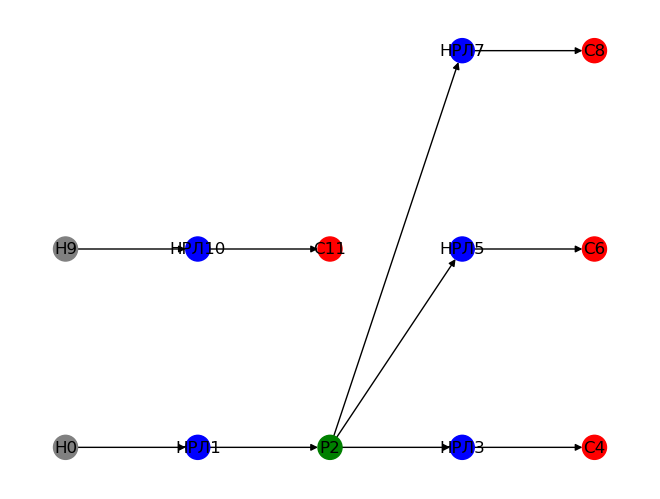

In [24]:
# Модель у которой получаем ветвь
model1 = Presets.single_line()
# Модель которой будем ее прививать
model2 = Presets.single_splitter(3)
model2.name = 'Модель для прививки'
# NRS_Revision.print_model_elements(model2)
Appraiser.print_GA_NRS_model_elements_state(model2)
# print_NRS_graph(model2)

# Получение ветви
branch = Branch().getBranch(model1, 'Н0').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
print(branch.branch_type)

# Прививка ветви
branch.drop_names()
model2.addElements(branch.elmnts).interpretate().check_pumps()
Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model2)

In [28]:
# Проверка расчета
aims = {'Q':15, '38дв':0, '51нп':0, '66нп':0, '89':0, '110':0, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 300, 'max_L': 300}
aims_not_more = {'150': 16, '77':10}
work_model = copy.deepcopy(model2)
work_model = fit(work_model, aims, aims_not_more, 5000)

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)
print('='*80)
Appraiser.print_metrics(work_model)
print('='*80)
print(aims)
print(aims_not_more)

0	0.5634590124071369	13.644344441678843
1	0.5586778351161968	13.859497419771145
6	0.5541556851989901	14.06299416604545
8	0.5431248581667175	10.559381382497708
23	0.5342362904719842	10.95936692876071
26	0.5258254397636394	11.337855210636233
28	0.4532485006431917	14.603817471056372
34	0.4449743184178547	14.97615567119654
46	0.4244161754016014	15.099382011512455
49	0.3785148459181282	14.966831933684235
62	0.3473323846581411	14.370042690383652
73	0.284151730047752	14.213172147851159
81	0.2764231309504391	14.560959107230243
115	0.26903854755386786	14.893265360075947
125	0.2677136115074163	14.952887482166268
139	0.25162515151370385	14.676868181883329
148	0.2444904401777768	14.997930192000045
168	0.22348733636346094	14.94306986364426
429	0.2225529172264246	15.014896053340372
600	0.2224810512397152	14.988352694212816
618	0.22237393344718567	15.00683011373812
775	0.2222385435572206	14.999265539925073
934	0.19870838123076243	16.618613529942266
936	0.1765815829615904	16.009872023819838
943	0.1696

Расстояние до Н0 300 м
Расстояние до Н9 300 м


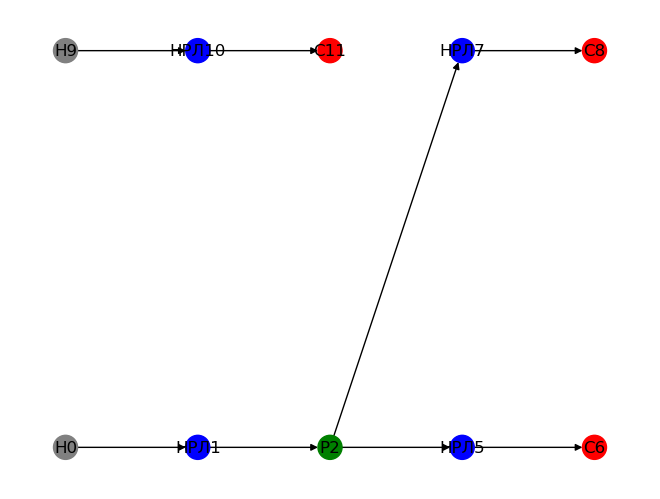

In [30]:
print_NRS_graph(work_model)

### Получение ветви от разветвления

Новая модель: Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Расстояние до Н0 80 м


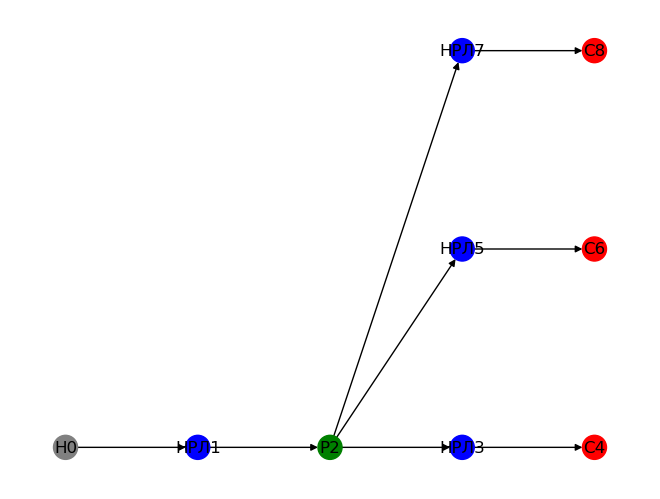

Новая модель: 
all:
  Р2
  НРЛ3
  С4
  НРЛ5
  С6
  НРЛ7
  С8
  НРЛ1
  Н0
in:
  Н0
out:
  С4
  С6
  С8
Расстояние до Н0 80 м


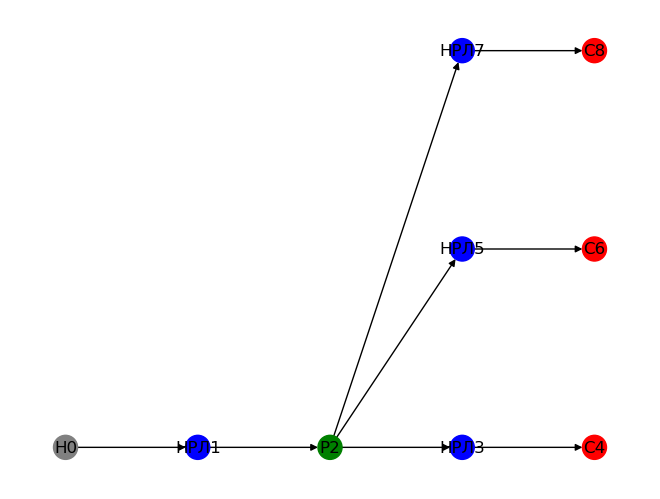

In [13]:
# Модель которой будем ее прививать
model = Presets.single_splitter(3)
model.name = 'Модель для получения ветви'
# NRS_Revision.print_model_elements(model2)
# Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(model)

# Получение ветви
branch = Branch().getBranch(model, 'Р2').deep_copy().interpretate()
NRS_Revision.print_model_elements(branch)
# print(branch.branch_type)

# # Прививка ветви
# branch.drop_names()
# model2.addElements(branch.elmnts).interpretate().check_pumps()
# Appraiser.print_GA_NRS_model_elements_state(model2)
print_NRS_graph(branch)